## Setup

In [7]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import seaborn as sns
from scipy.stats import f_oneway  # ANOVA test
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

In [8]:
#results_df = pd.read_csv('../../data/topic_model_results.csv',  lineterminator='\n', encoding='utf8')

In [9]:
results_df = pd.read_csv('./topic_model_results.csv',  lineterminator='\n', encoding='utf8')

In [10]:
results_df.head()

,text,timestamp,username,link,link_id,parent_id,id,subreddit_id,moderation\r,hateful Score,hateful HR,toxic Score,toxic HR\r,Topic Number,Topic\r
0,i think most singaporeans dont give a damn who...,11/4/2020 15:49,invigo79,/r/singapore/comments/fz7vtl/im_quite_interest...,t3_fz7vtl,t3_fz7vtl,fn3gbrg,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-0.582897,0,-0.419338,0,0,Political\r
1,fair point the secrecy aspect of it slipped my...,3/4/2020 9:59,potatetoe_tractor,/r/singapore/comments/fu3axm/government_to_tab...,t3_fu3axm,t1_fmasya5,fmau5k3,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-1.116736,0,-1.869363,0,4,Relationships\r
2,range,15/2/2020 15:07,CrossfittJesus,/r/singapore/comments/f4ac70/what_is_ps_defens...,t3_f4ac70,t3_f4ac70,fhp05xc,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-1.027191,0,-0.798016,0,4,Relationships\r
3,gt this is binary thinking because you think t...,4/6/2020 7:07,nomad80,/r/singapore/comments/gw55cx/notoracism/fsu4fyd/,t3_gw55cx,t1_fsu3dsf,fsu4fyd,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-0.419287,0,1.119165,1,5,Crime\r
4,boo boo poor u lmao,31/10/2020 13:52,pirorok,/r/singapore/comments/jl6abo/rsingapore_random...,t3_jl6abo,t1_gap4e9y,gap4vkl,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-0.952112,0,1.197503,1,9,Unknown\r


In [11]:
# Remove \r from column names
results_df.columns = results_df.columns.str.strip()

# Strip \r and other whitespace characters from a specific column (e.g., 'column_name')
results_df['Topic'] = results_df['Topic'].str.strip()

results_df.head()

,text,timestamp,username,link,link_id,parent_id,id,subreddit_id,moderation,hateful Score,hateful HR,toxic Score,toxic HR,Topic Number,Topic
0,i think most singaporeans dont give a damn who...,11/4/2020 15:49,invigo79,/r/singapore/comments/fz7vtl/im_quite_interest...,t3_fz7vtl,t3_fz7vtl,fn3gbrg,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-0.582897,0,-0.419338,0,0,Political
1,fair point the secrecy aspect of it slipped my...,3/4/2020 9:59,potatetoe_tractor,/r/singapore/comments/fu3axm/government_to_tab...,t3_fu3axm,t1_fmasya5,fmau5k3,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-1.116736,0,-1.869363,0,4,Relationships
2,range,15/2/2020 15:07,CrossfittJesus,/r/singapore/comments/f4ac70/what_is_ps_defens...,t3_f4ac70,t3_f4ac70,fhp05xc,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-1.027191,0,-0.798016,0,4,Relationships
3,gt this is binary thinking because you think t...,4/6/2020 7:07,nomad80,/r/singapore/comments/gw55cx/notoracism/fsu4fyd/,t3_gw55cx,t1_fsu3dsf,fsu4fyd,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-0.419287,0,1.119165,1,5,Crime
4,boo boo poor u lmao,31/10/2020 13:52,pirorok,/r/singapore/comments/jl6abo/rsingapore_random...,t3_jl6abo,t1_gap4e9y,gap4vkl,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-0.952112,0,1.197503,1,9,Unknown


In [12]:
# rename new columns
results_df.rename(columns={
    'hateful Score': 'hateful_score',
    'hateful HR': 'hateful_prediction',
    'toxic Score': 'toxic_score',
    'toxic HR': 'toxic_prediction',
    'Topic Number': 'topic_number',
    'Topic': 'topic'
}, inplace=True)

results_df.head()

,text,timestamp,username,link,link_id,parent_id,id,subreddit_id,moderation,hateful_score,hateful_prediction,toxic_score,toxic_prediction,topic_number,topic
0,i think most singaporeans dont give a damn who...,11/4/2020 15:49,invigo79,/r/singapore/comments/fz7vtl/im_quite_interest...,t3_fz7vtl,t3_fz7vtl,fn3gbrg,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-0.582897,0,-0.419338,0,0,Political
1,fair point the secrecy aspect of it slipped my...,3/4/2020 9:59,potatetoe_tractor,/r/singapore/comments/fu3axm/government_to_tab...,t3_fu3axm,t1_fmasya5,fmau5k3,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-1.116736,0,-1.869363,0,4,Relationships
2,range,15/2/2020 15:07,CrossfittJesus,/r/singapore/comments/f4ac70/what_is_ps_defens...,t3_f4ac70,t3_f4ac70,fhp05xc,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-1.027191,0,-0.798016,0,4,Relationships
3,gt this is binary thinking because you think t...,4/6/2020 7:07,nomad80,/r/singapore/comments/gw55cx/notoracism/fsu4fyd/,t3_gw55cx,t1_fsu3dsf,fsu4fyd,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-0.419287,0,1.119165,1,5,Crime
4,boo boo poor u lmao,31/10/2020 13:52,pirorok,/r/singapore/comments/jl6abo/rsingapore_random...,t3_jl6abo,t1_gap4e9y,gap4vkl,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-0.952112,0,1.197503,1,9,Unknown


In [13]:
# convert data to appropriate datatypes
results_df['text'] = results_df['text'].astype(str)
results_df['timestamp'] = pd.to_datetime(results_df['timestamp'], format='%d/%m/%Y %H:%M')
results_df['username'] = results_df['username'].astype(str)
results_df['link'] = results_df['link'].astype(str)
results_df['link_id'] = results_df['link_id'].astype(str)
results_df['parent_id'] = results_df['parent_id'].astype(str)
results_df['id'] = results_df['id'].astype(str)
results_df['subreddit_id'] = results_df['subreddit_id'].astype(str)
results_df['moderation'] = results_df['moderation'].tolist()
results_df['hateful_score'] = results_df['hateful_score'].astype('float32')
results_df['hateful_prediction'] = results_df['hateful_prediction'].astype('int16')
results_df['toxic_score'] = results_df['toxic_score'].astype('float32')
results_df['toxic_prediction'] = results_df['toxic_prediction'].astype('int16')
results_df['topic_number'] = results_df['topic_number'].astype('category')
results_df['topic'] = results_df['topic'].astype('category')

In [14]:
# extract date from datetime stamp
results_df['timestamp'] = results_df['timestamp'].dt.date
# results_df['timestamp'].head()

### Scope of Analysis: Consistent Toxicity & Hatefulness

### Analysis Scope and Topic Selection

In this analysis, we focus on two main hypotheses:

1. **Consistent Toxicity & Hatefulness**:
   - Hypothesis: Topics that reflect Singapore’s societal structure (e.g., *Race & Religion*, *Relationships*, *Education*, *Housing*, *Work*, and *Transport*.) may exhibit ongoing, consistent levels of toxicity and hatefulness. They tend to be more frequently discussed.
   - Approach: Examine these topics to see if they consistently attract toxic or hateful content, reflecting broader societal tensions or recurrent themes.

2. **Big Spike Events**:
   - Hypothesis: Certain high-profile events (e.g., Covid-19, General Elections, significant crime incidents) trigger temporary but intense increases in toxic or hateful comments. They tend to be occasional but intense discussions.
   - Approach: Isolate these topics and evaluate if there are observable spikes in scores during key time periods.

The primary focus of this analysis is to explore **Consistent Toxicity & Hatefulness** across specific categories of topics identified in Singapore’s Reddit discussions. This focus is based on observed and hypothesized patterns of toxicity and hatefulness in:
  - **Controversial Topics** (e.g., Race & Religion) — reflecting sensitive societal issues that may have unique cultural implications in Singapore.
  - **Everyday Miscellaneous Rants** (e.g., Relationships, Education, Housing, and Work) — representing routine frustrations that may also contribute to consistent negativity online.

#### Approach to Topic Selection
Topics for the consistent toxicity and hatefulness analysis were selected based on:
  1. **Topic Modeling Results**: Initial exploratory analysis identified several prevalent discussion themes using seeded topics. Each seed topic was chosen based on keywords relevant to Singapore’s sociopolitical context.
  2. **Sensitivity of Topics**: Research and observations indicate that topics related to race, religion, and politics in Singapore often evoke strong opinions and are therefore likely to exhibit consistent toxicity and hatefulness.
  3. **Relevance to Research Questions**: The analysis aims to shed light on how toxicity and hatefulness are distributed across sensitive and everyday topics, helping inform social media moderation and public policy.

This scope provides a balanced view of toxic and hateful patterns in both sensitive and routine contexts within Singaporean discussions.

In [15]:
# Filtering for consistent topics
consistent_topics = ['Race & Religion', 'Relationships', 'Education', 'Housing', 'Work', "Transport"]
consistent_df = results_df[results_df['topic'].isin(consistent_topics)]

## 2. Comparative Analysis of Toxicity and Hatefulness Scores by Topic

First, we look at the general statistics and distribution of all the topics.

### 2.1: Descriptive Statistics & Boxplots

/var/folders/yk/rjbvhtb15ts24mbrqtq665zr0000gn/T/ipykernel_32272/1656944148.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  topic_stats = results_df.groupby('topic')[['toxic_score', 'hateful_score']].agg(['mean', 'median', 'std']).reset_index()


             topic toxic_score                     hateful_score            \
                          mean    median       std          mean    median   
0         Covid-19   -0.472685 -0.535648  0.578988     -0.968609 -0.993017   
1            Crime   -0.480970 -0.545571  0.577028     -0.970119 -0.995348   
2        Education   -0.477676 -0.541311  0.577727     -0.967761 -0.993437   
3          Housing   -0.486003 -0.550627  0.577059     -0.972205 -0.995324   
4        Political   -0.486639 -0.552154  0.578058     -0.971467 -0.995549   
5  Race & Religion   -0.481562 -0.546193  0.580083     -0.969118 -0.994141   
6    Relationships   -0.480626 -0.543351  0.581723     -0.968313 -0.993761   
7        Transport   -0.478342 -0.543079  0.579202     -0.969834 -0.994252   
8          Unknown   -0.445050 -0.512912  0.591850     -0.960016 -0.987681   
9             Work   -0.481812 -0.546468  0.582189     -0.968115 -0.992473   

             
        std  
0  0.192525  
1  0.195153  
2  0.19

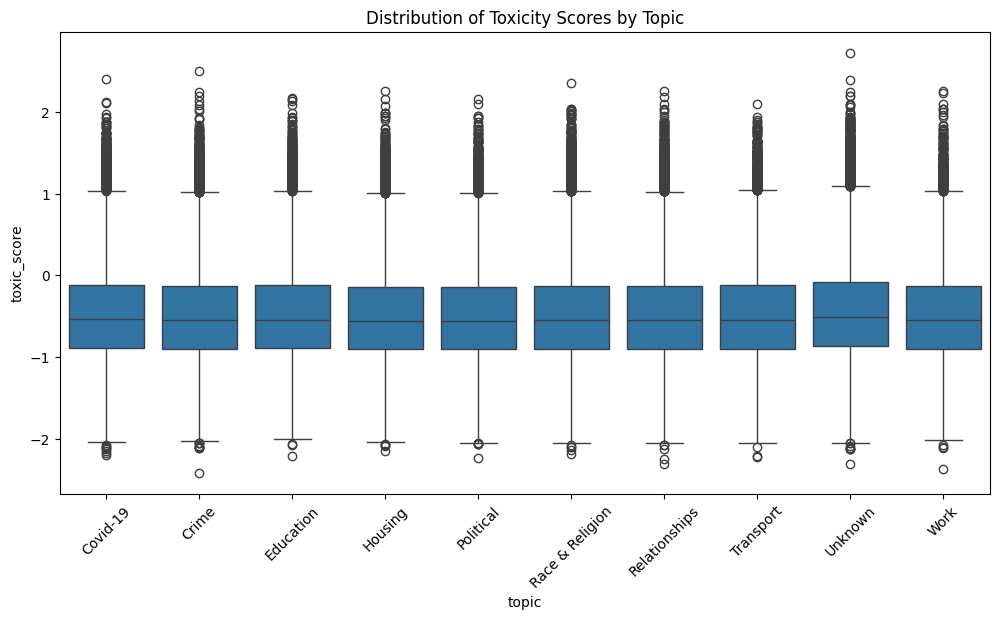

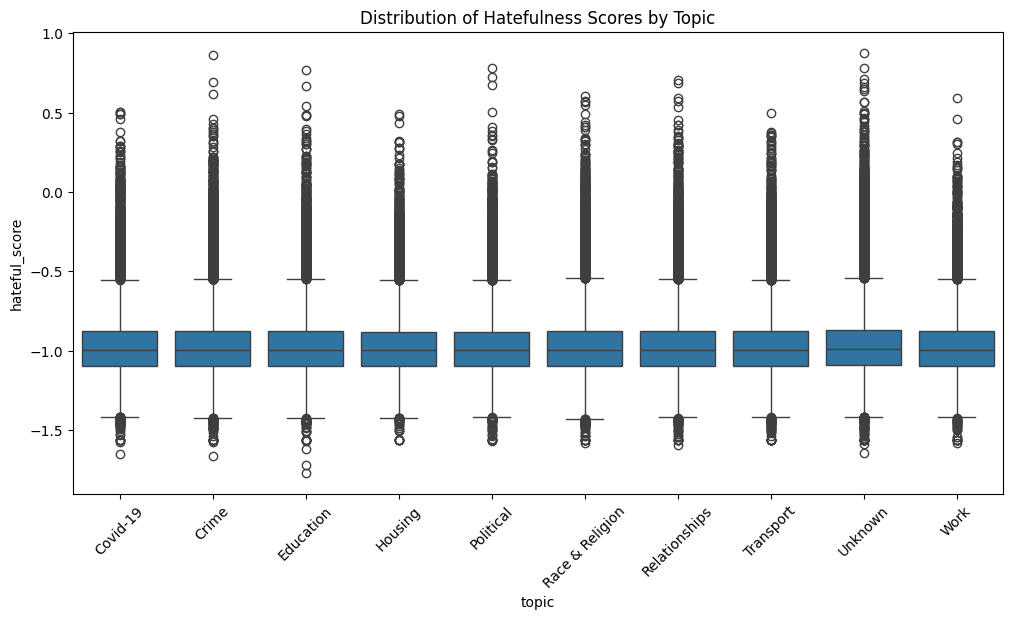

In [16]:
# Group by topic and calculate descriptive statistics for toxic and hateful scores
topic_stats = results_df.groupby('topic')[['toxic_score', 'hateful_score']].agg(['mean', 'median', 'std']).reset_index()
print(topic_stats)

# Boxplot for distribution of toxicity and hatefulness across topics
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='topic', y='toxic_score')
plt.title('Distribution of Toxicity Scores by Topic')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='topic', y='hateful_score')
plt.title('Distribution of Hatefulness Scores by Topic')
plt.xticks(rotation=45)
plt.show()

Based on the statistics, the means if the topics are all relatively close to one another, amidst the toxicity and hatefulness scores. This may be due to the denseness of the dataset, having so many entries that each comment's contribution is infinitesimal. Since toxicity and hatefulness scores are uniformly distributed across topics, this may imply a baseline level of toxicity/ hatefulness present in all discussions. This finding is insightful when understanding that certain topics do not disproportionately drive toxicity.

Since most of the statistics are similar, what makes some topics more significant is the outliers beyond the whiskers. Topics with numerous outliers may suggest isolated instances of heightened toxicity or hatefulness.

For toxicity, topics like crime, covid-19, and unknown have a more significant spread of outliers. Similarly, for hatefulness, topics like crime, education, political and unknown have more prominent range of outliers. This means that there may be some underlying extremeties. Especially for the topic of education which has a significant spread of outliers below -1.5 also, this could imply that the education system strongly satisfies some people (hence the good scores) while disadvantaging a significant number of people too.

### Histogram by topic to visualise score distributions more clearly

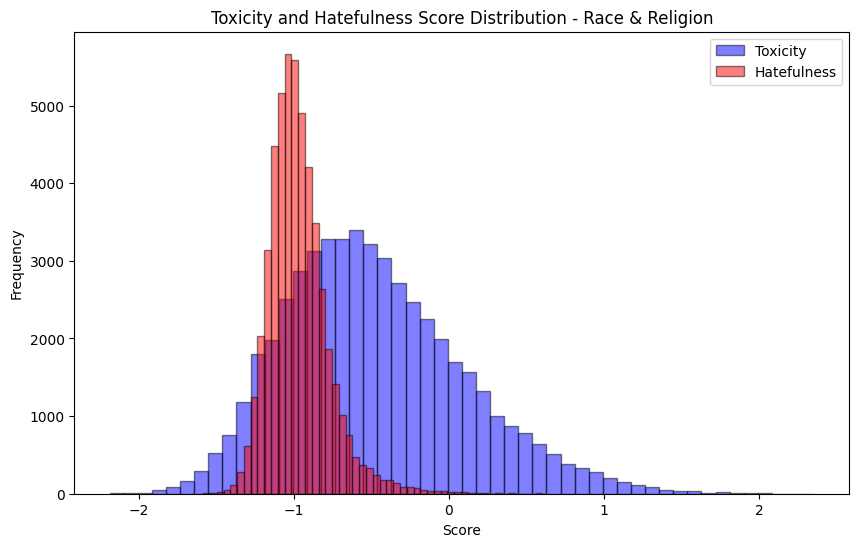

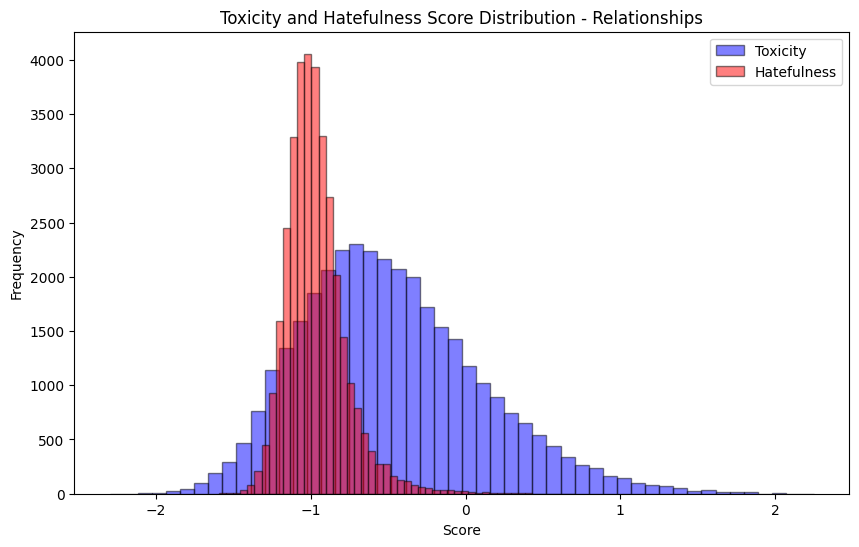

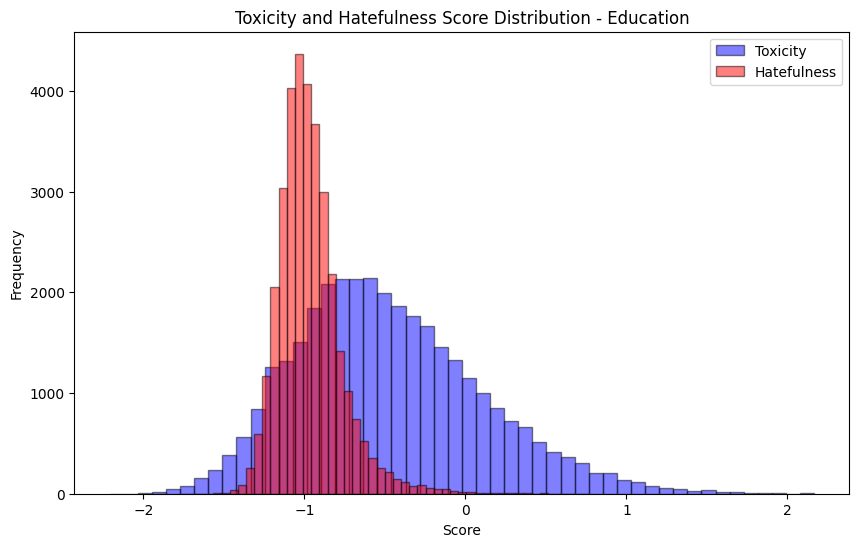

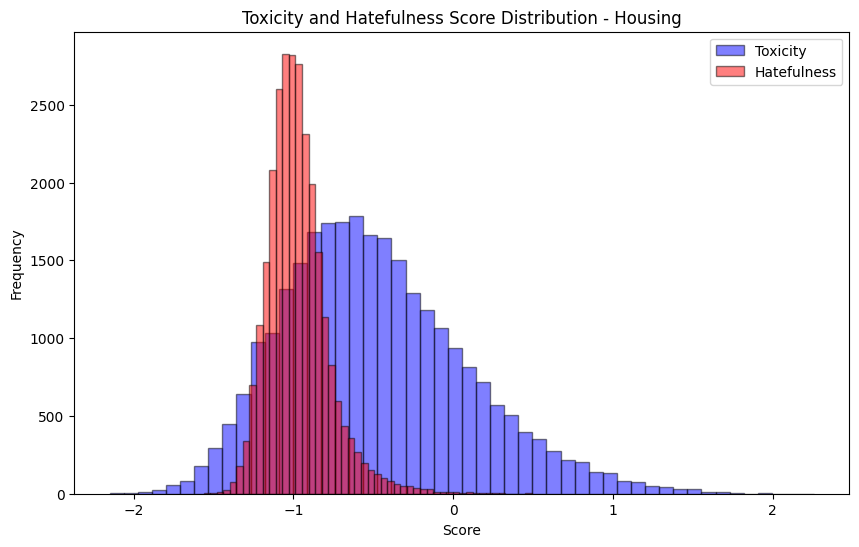

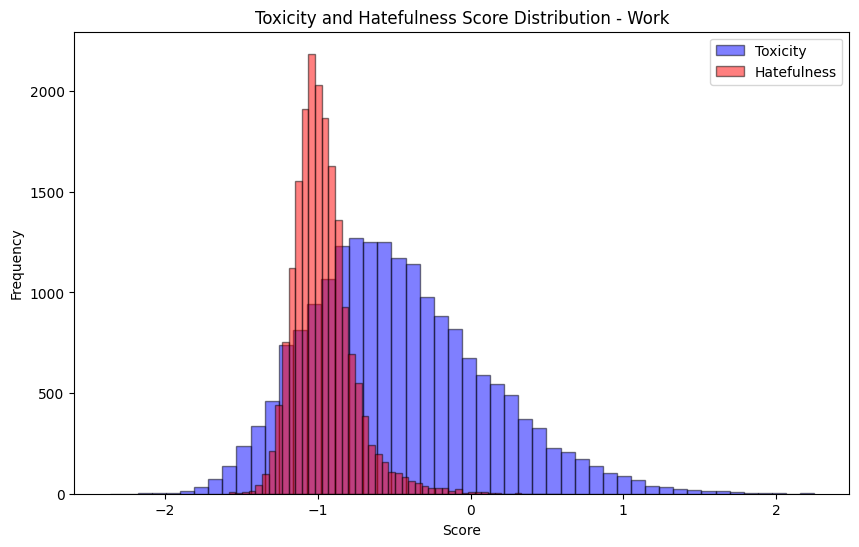

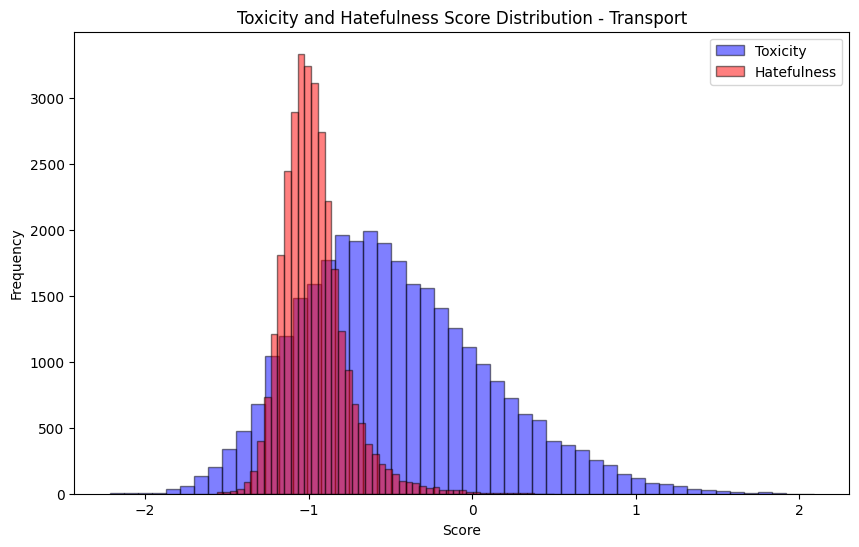

In [17]:
# Plot toxicity and hatefulness scores in a single histogram for each topic
for topic in consistent_topics:
    topic_data = consistent_df[consistent_df['topic'] == topic]
    
    plt.figure(figsize=(10, 6))
    plt.hist(topic_data['toxic_score'], bins=50, alpha=0.5, color='blue', label='Toxicity', edgecolor='black')
    plt.hist(topic_data['hateful_score'], bins=50, alpha=0.5, color='red', label='Hatefulness', edgecolor='black')
    
    plt.title(f"Toxicity and Hatefulness Score Distribution - {topic}")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.legend(loc='upper right')
    plt.show()

We can observe the difference in frequencies of the different topics.
- Hatefulness has its highest count of over 6000 for race & religion, and the lowest count of 2100 for work.
- Toxicity has its highest count of 3100 for race & religion, and the lowest of 1200 for work.

### Scatter plots to show the relationship between toxicity and hatefulness within topics, identifying topics with higher correlations.

To observe any clusters or correlations between toxicity and hatefulness across different topics. Topics with higher toxicity-hatefulness correlations are likely more controversial.

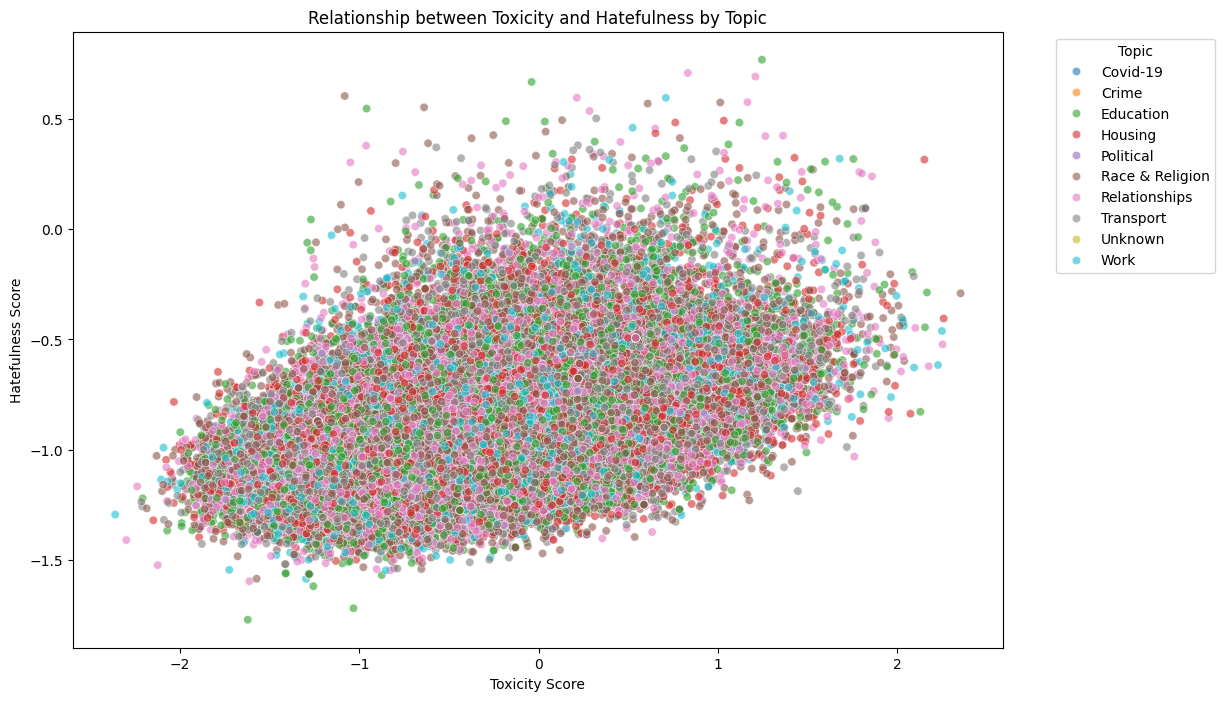

In [18]:
# Scatter plot for toxicity vs. hatefulness by topic
plt.figure(figsize=(12, 8))
sns.scatterplot(data=consistent_df, x='toxic_score', y='hateful_score', hue='topic', alpha=0.6)
plt.title('Relationship between Toxicity and Hatefulness by Topic')
plt.xlabel('Toxicity Score')
plt.ylabel('Hatefulness Score')
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Quite hard to tell, there are too many data points... so we decided to do a scatter plot matrix whereby each plot will represent 1 topic, displayed side by side such that we can see the relationships between hatefulness and toxicity within each topic clearly. We will also use a heatmap since there are many points, so the density can tell us more about the trend among the topics

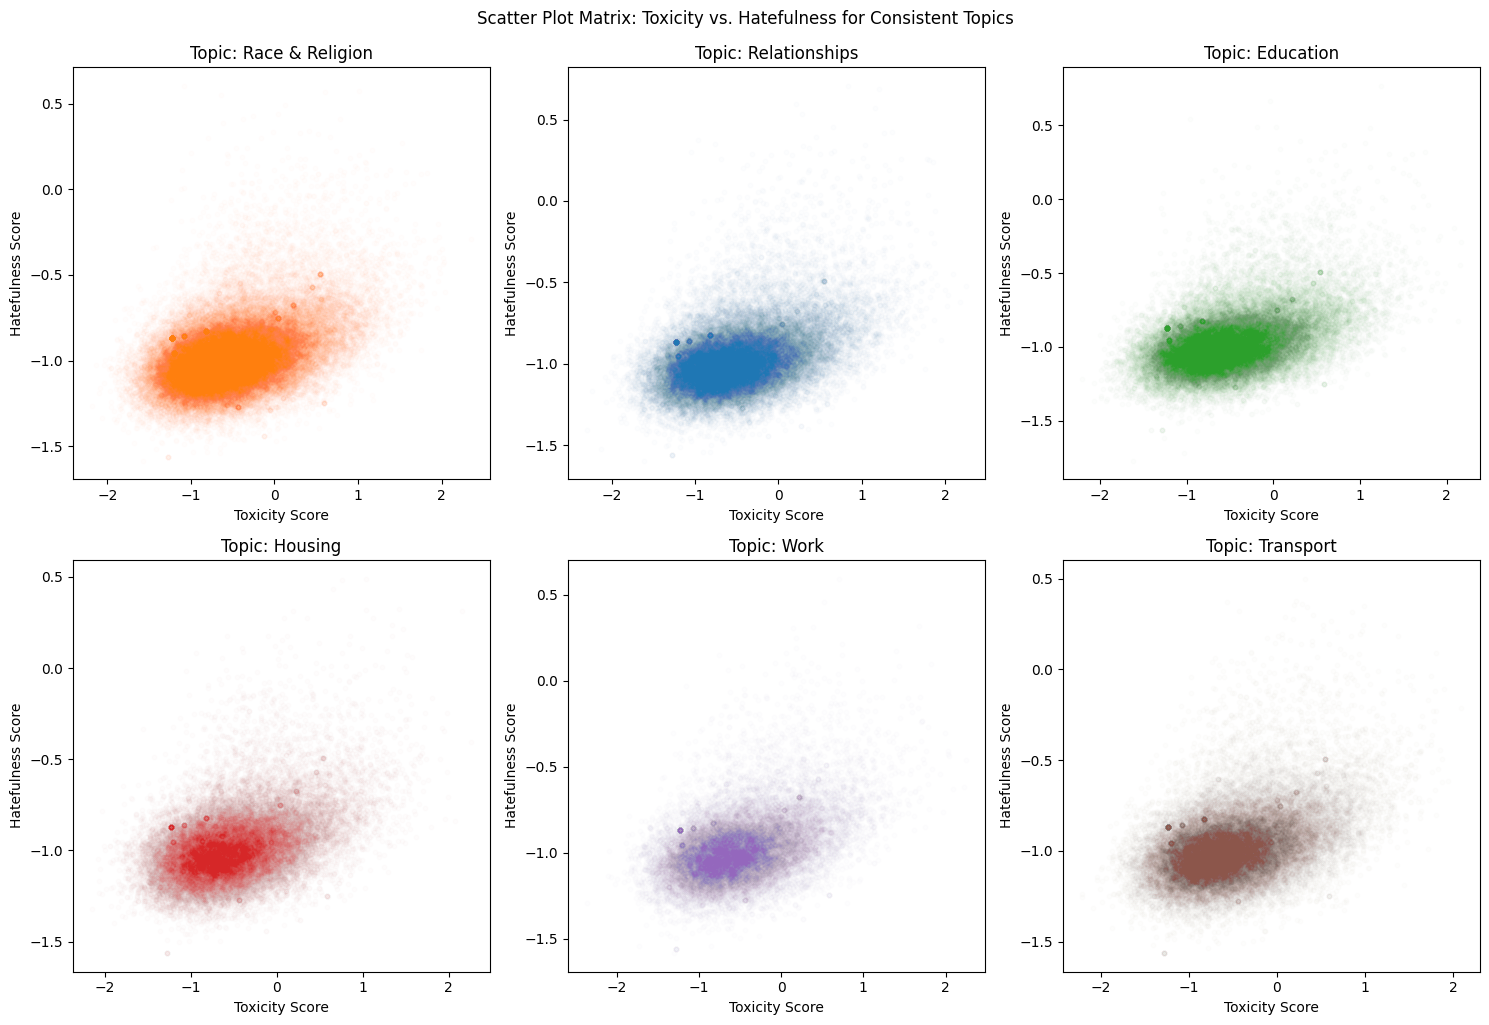

In [34]:
# Define consistent topics and their colors
consistent_topics = ['Race & Religion', 'Relationships', 'Education', 'Housing', 'Work', 'Transport']
topic_palette = {
    'Race & Religion': '#FF7F0E', 
    'Relationships': '#1F77B4', 
    'Education': '#2CA02C', 
    'Housing': '#D62728', 
    'Work': '#9467BD', 
    'Transport': '#8C564B'
}

# Set up a 2x3 grid for the six plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()  # Flatten to iterate over for each topic

# Plot each topic on a separate scatter plot
for idx, topic in enumerate(consistent_topics):
    # Filter data for the current topic
    topic_data = consistent_df[consistent_df['topic'] == topic]
    
    # Create scatter plot with transparency to show density
    axes[idx].scatter(
        topic_data['toxic_score'], 
        topic_data['hateful_score'], 
        color=topic_palette[topic], 
        alpha=0.01,
        s=10
    )
    
    # Set title and labels for each subplot
    axes[idx].set_title(f'Topic: {topic}')
    axes[idx].set_xlabel('Toxicity Score')
    axes[idx].set_ylabel('Hatefulness Score')

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.suptitle("Scatter Plot Matrix: Toxicity vs. Hatefulness for Consistent Topics", y=1.02)
plt.show()

We set the transparency of each point to be extremely low (alpha=0.01) because the dataset is already extremely dense to begin with, and there are plenty of points per topic. So in order to get accurate insights in toxicity and hatefulness. From the scatter plot matrix, we can see that the topic of race and religion has the biggest spread of highly concentrated points, while work has the smallest spread.

### 2.2: Hypothesis Testing (ANOVA & Post-hoc)

- ANOVA: This test determines if there are significant differences in toxicity and hatefulness scores across the topics. A low p-value (close to 0) in ANOVA results suggests that the topic categories likely influence score variance.
- Tukey Test: The Tukey Honest Significant Difference (HSD) test is a post hoc analysis following ANOVA. It identifies which specific pairs of groups (topics) differ significantly from each other in their mean scores. It’s useful because ANOVA only tells us that there’s a difference somewhere, but not where.

In [15]:
# Perform ANOVA for toxic and hateful scores across topics
anova_toxic = f_oneway(*(consistent_df[consistent_df['topic'] == topic]['toxic_score'] for topic in consistent_df['topic'].unique()))
anova_hateful = f_oneway(*(consistent_df[consistent_df['topic'] == topic]['hateful_score'] for topic in consistent_df['topic'].unique()))
print("ANOVA Toxicity:", anova_toxic)
print("ANOVA Hatefulness:", anova_hateful)

# Post-hoc test if ANOVA shows significance
consistent_df['topic'] = consistent_df['topic'].astype(str)
tukey_result_toxic = pairwise_tukeyhsd(endog=consistent_df['toxic_score'], groups=consistent_df['topic'], alpha=0.05)
print(tukey_result_toxic)

tukey_result_hateful = pairwise_tukeyhsd(endog=consistent_df['hateful_score'], groups=consistent_df['topic'], alpha=0.05)
print(tukey_result_hateful)

ANOVA Toxicity: F_onewayResult(statistic=0.781073894962961, pvalue=0.5631207251815238)
ANOVA Hatefulness: F_onewayResult(statistic=2.023559465599139, pvalue=0.07197045259519581)
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------
      Education         Housing  -0.0083 0.4866 -0.0217 0.0051  False
      Education Race & Religion  -0.0039 0.9316 -0.0155 0.0077  False
      Education   Relationships   -0.003 0.9856 -0.0156 0.0097  False
      Education       Transport  -0.0007    1.0 -0.0136 0.0123  False
      Education            Work  -0.0041 0.9698 -0.0191 0.0108  False
        Housing Race & Religion   0.0044 0.9101 -0.0079 0.0168  False
        Housing   Relationships   0.0054 0.8611  -0.008 0.0187  False
        Housing       Transport   0.0077 0.5989  -0.006 0.0213  False
        Housing            Work   0.0042 0.9731 -0.0

/var/folders/yk/rjbvhtb15ts24mbrqtq665zr0000gn/T/ipykernel_85125/3329125289.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consistent_df['topic'] = consistent_df['topic'].astype(str)


         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------
      Education         Housing  -0.0044 0.0543 -0.0089    0.0  False
      Education Race & Religion  -0.0014 0.9186 -0.0052 0.0025  False
      Education   Relationships  -0.0006 0.9991 -0.0048 0.0037  False
      Education       Transport  -0.0021 0.7489 -0.0064 0.0023  False
      Education            Work  -0.0004    1.0 -0.0054 0.0047  False
        Housing Race & Religion   0.0031 0.2731  -0.001 0.0072  False
        Housing   Relationships   0.0039 0.1287 -0.0006 0.0084  False
        Housing       Transport   0.0024 0.6776 -0.0022 0.0069  False
        Housing            Work   0.0041 0.2216 -0.0011 0.0093  False
Race & Religion   Relationships   0.0008 0.9913  -0.003 0.0047  False
Race & Religion       Transport  -0.0007 0.9956 -0.0047 0.0032  False
Race & Religion     

**ANOVA Results**

The ANOVA test reveals that there is no statistically significant difference in toxicity scores across topics (p = 0.563), indicating that on average, toxicity levels remain consistent across topics. However, hatefulness scores do show a near-significant variation across topics (p = 0.072), hinting at differences in hatefulness intensity depending on the topic. This suggests that certain topics may indeed foster stronger critical or polarized responses among users, warranting closer analysis.

**Tukey HSD Insights**

The Tukey HSD test further investigates these topic-specific differences:

- Education vs. Housing: Although not statistically significant, the close-to-significant difference (p = 0.0543) between Education and Housing suggests slight variations in how users discuss these topics. This could indicate different societal pressures or emotional responses—education stress versus housing challenges—that lead to varied expressions of sentiment.
- While the Tukey HSD did not reveal additional significant pairwise differences, these small, non-significant variations suggest that the model could benefit from nuanced adjustments based on societal expectations or values associated with each topic.

**Explanation of Tukey HSD**

The Tukey HSD test identifies pairs of topics with statistically different mean scores, providing more granularity by isolating specific topics that contribute to the overall variance observed in the ANOVA. This analysis is valuable in pinpointing which topics are more prone to toxic or hateful discourse, thus guiding targeted moderation or policy adjustments for certain topics that may carry higher risks for content escalation.

### ANOVA and Tukey HSD Analysis (Consistent Topics)

- **ANOVA Results**:
  - For toxicity, no significant difference was detected across topics (`p = 0.525`), indicating similar average toxicity levels.
  - For hatefulness, however, a significant difference was found across topics (`p = 0.046`), suggesting that some topics have higher hatefulness levels than others.

- **Tukey HSD Results**:
  - The post hoc Tukey test for hatefulness scores showed a significant difference between **Education** and **Housing** topics (`p = 0.0387`). This finding highlights that **Housing** has a slightly higher hatefulness score than **Education**.

## 3. Cross-Validation of Toxicity and Hatefulness Predictions with Scores

### 3.1: Comparing Scores with Predictions (True/False Positive & Negative Rates)

In [16]:
# True Positive Rate, False Positive Rate, False Negative Rate calculation by topic
def calculate_metrics(group):
    tp = sum((group['toxic_prediction'] == 1) & (group['toxic_score'] > 0))
    fp = sum((group['toxic_prediction'] == 1) & (group['toxic_score'] <= 0))
    fn = sum((group['toxic_prediction'] == 0) & (group['toxic_score'] > 0))
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tp) if (fp + tp) > 0 else 0
    return pd.Series({'TPR': tpr, 'FPR': fpr, 'FN': fn})

topic_metrics = consistent_df.groupby('topic').apply(calculate_metrics).reset_index()
print(topic_metrics)

             topic       TPR  FPR      FN
0        Education  0.814971  0.0  1231.0
1          Housing  0.810492  0.0   997.0
2  Race & Religion  0.815897  0.0  1839.0
3    Relationships  0.818249  0.0  1221.0
4        Transport  0.811986  0.0  1167.0
5             Work  0.819083  0.0   675.0


### Comparing Scores with Predictions (Consistent Topics)

- **True Positive Rate (TPR)**:
  - The model achieves a high TPR across all topics (ranging from 0.810 to 0.819), indicating it detects most toxic and hateful comments effectively within consistent topics.

- **False Positive Rate (FPR)**:
  - FPR is consistently 0, meaning there are no instances of falsely identifying non-toxic/hateful comments as toxic/hateful. 
  - Or, zero FPR might indicate either over-filtering or a conservative threshold.

- **False Negatives (FN)**:
  - **Race & Religion** has the highest FN count (1839), indicating a possible under-detection in this sensitive topic, which might lead to an underestimation of hatefulness in this area. This is critical for consistent toxicity topics.

The cross-validation results reveal interesting patterns in topic-specific model performance, particularly in sensitivity (True Positive Rate, TPR) and False Negative counts.

- High TPR but Significant FN in Race & Religion: Although the model achieves a high TPR across all topics, high FN counts in Race & Religion suggest challenges in detecting hatefulness in subtle or coded language. This indicates the need for potentially lowering the detection threshold or incorporating more contextual cues to capture nuanced hatefulness.
- Zero FPR Across Topics: A zero False Positive Rate shows the model's conservative approach, minimizing incorrect labeling of non-toxic/hateful posts. This conservative threshold may reduce user complaints but could allow more borderline hatefulness to pass undetected.

These findings suggest that targeted threshold adjustments for specific topics (e.g., Race & Religion) could improve FN rates while maintaining acceptable TPR levels.

### 3.2: Threshold Sensitivity Analysis

/var/folders/yk/rjbvhtb15ts24mbrqtq665zr0000gn/T/ipykernel_85125/42784379.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consistent_df['adjusted_toxic_pred'] = np.where(consistent_df['toxic_score'] >= threshold, 1, 0)


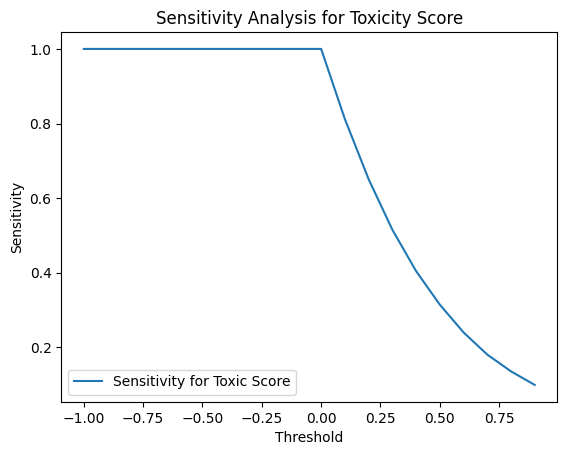

In [17]:
# Sensitivity Analysis: Varying thresholds for toxicity and hatefulness
thresholds = np.arange(-1, 1, 0.1)
sensitivity_results = []

for threshold in thresholds:
    consistent_df['adjusted_toxic_pred'] = np.where(consistent_df['toxic_score'] >= threshold, 1, 0)
    tp = sum((consistent_df['adjusted_toxic_pred'] == 1) & (consistent_df['toxic_score'] > 0))
    fn = sum((consistent_df['adjusted_toxic_pred'] == 0) & (consistent_df['toxic_score'] > 0))
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    sensitivity_results.append((threshold, sensitivity))

# Plot sensitivity results
thresholds, sensitivities = zip(*sensitivity_results)
plt.plot(thresholds, sensitivities, label='Sensitivity for Toxic Score')
plt.xlabel('Threshold')
plt.ylabel('Sensitivity')
plt.title('Sensitivity Analysis for Toxicity Score')
plt.legend()
plt.show()

### Sensitivity Analysis
The graph shows how the model's sensitivity changes as the threshold for toxicity and hatefulness scores increases.

- **Findings**:
  - The model is highly sensitive at lower thresholds but loses sensitivity as the threshold increases beyond 0.
  - This implies a trade-off: Lower thresholds result in high detection rates but may capture less severe content as toxic/hateful.
  - For sensitive topics, maintaining a lower threshold may be more effective to ensure high detection of harmful content.
- **Interpretation**:
This pattern suggests that lower thresholds may be more effective for catching all types of toxic/hateful content, especially for sensitive topics. However, a balance must be struck to avoid excessively flagging neutral or mildly critical posts. Tailoring threshold levels by topic could mitigate over- or under-detection, depending on each topic's general sentiment patterns.

Policy Implications: For topics like race & religion, a lower threshold could be set to ensure higher sensitivity, capturing even marginally toxic content.

## 4. In-depth Analysis of Consistent Toxicity & Hatefulness Topics

### 4.1: Focusing on High-Toxicity and High-Hatefulness Topics

In [18]:
# Proportion of high-toxic and high-hateful comments within each sensitive topic
high_toxicity = consistent_df[consistent_df['toxic_score'] > 0.5]
high_hatefulness = consistent_df[consistent_df['hateful_score'] > 0.5]

high_toxic_proportion = high_toxicity[high_toxicity['topic'].isin(consistent_topics)].groupby('topic').size() / consistent_df.groupby('topic').size()
high_hateful_proportion = high_hatefulness[high_hatefulness['topic'].isin(consistent_topics)].groupby('topic').size() / consistent_df.groupby('topic').size()

print("High Toxicity Proportion:", high_toxic_proportion)
print("High Hatefulness Proportion:", high_hateful_proportion)

High Toxicity Proportion: topic
Education          0.060808
Housing            0.060363
Race & Religion    0.062142
Relationships      0.061892
Transport          0.062460
Work               0.059919
dtype: float64
High Hatefulness Proportion: topic
Education          0.000089
Housing                 NaN
Race & Religion    0.000078
Relationships      0.000144
Transport          0.000032
Work               0.000053
dtype: float64


### High Toxicity and High Hatefulness Proportion (Consistent Topics)

- **High Toxicity Topics**:
  - **Race & Religion** has the highest proportion of toxic comments (6.2%), followed by **Relationships** (6.19%), indicating that these topics frequently contain toxic content. This reflects the sensitive nature of discussions surrounding these areas. The prevalence of toxic discussions in these topics aligns with societal debates and polarized viewpoints.

- **High Hatefulness Topics**:
  - **Relationships** shows the highest proportion of hateful comments (0.014%), with **Education** and **Race & Religion** following. 
    - The presence of hatefulness, even at a lower level, suggests that these topics may require more vigilant moderation due to the potential for subtle aggression or hostility.
  - **Housing** has a NaN value for hateful comments, likely due to fewer comments in this category, meaning not enough data for hateful content detection.
    - The lack of hateful posts in the Housing topic is expected given its typically neutral or informational tone. It’s likely that discussions here focus on logistical or factual elements, thus avoiding more hateful expressions.

- **Implications**:
  - Topics like **Race & Religion** and **Relationships** are prone to higher toxicity and hatefulness, suggesting these areas might benefit from stricter moderation or policy guidelines.
  - In-depth Qualitative Analysis: Topics with high toxicity/hatefulness should undergo qualitative review to identify recurrent patterns or keywords.

### Text analysis in high-toxicity topics - extracting and analysing the most common keywords/ phrases to identify specific issues

In [19]:
# Custom stop words list for high-toxicity analysis
custom_stopwords = ['just', 'like', 'people', 'dont', 'know', 'think', 'time', 'say', 'want', 'make', 'need', 'really', 'im', 'youre', 'gt']

# Re-initialize vectorizer with custom stop words
vectorizer = CountVectorizer(stop_words='english', max_features=20)
vectorizer.set_params(stop_words=list(vectorizer.get_stop_words()) + custom_stopwords)

# Apply the vectorizer to high-toxicity text
high_toxic_text = consistent_df[consistent_df['toxic_score'] > 0.5]['text']
high_toxic_terms = vectorizer.fit_transform(high_toxic_text)
high_toxic_term_frequencies = np.array(high_toxic_terms.sum(axis=0)).flatten()

# Display most common terms without generic stop words
high_toxic_terms_df = pd.DataFrame({'term': vectorizer.get_feature_names_out(), 'frequency': high_toxic_term_frequencies})
print(high_toxic_terms_df.sort_values(by='frequency', ascending=False))

         term  frequency
4        fuck        981
15       shit        744
5     fucking        699
10        lol        577
16  singapore        526
2    comments        515
17     stupid        511
7         got        507
6        good        456
8         guy        451
13       post        443
14      right        428
18      thats        414
12        pap        411
1     chinese        391
0      better        390
11        man        367
3         did        358
9        lmao        349
19        way        346


### 4.2: Temporal Analysis of Toxicity and Hatefulness Scores for Consistent Topics

/var/folders/yk/rjbvhtb15ts24mbrqtq665zr0000gn/T/ipykernel_85125/3790589649.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consistent_df['timestamp'] = pd.to_datetime(consistent_df['timestamp'], errors='coerce')
/var/folders/yk/rjbvhtb15ts24mbrqtq665zr0000gn/T/ipykernel_85125/3790589649.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  consistent_quarterly_avg = consistent_df.groupby(['topic', pd.Grouper(freq='Q')])[['toxic_score', 'hateful_score']].mean().reset_index()


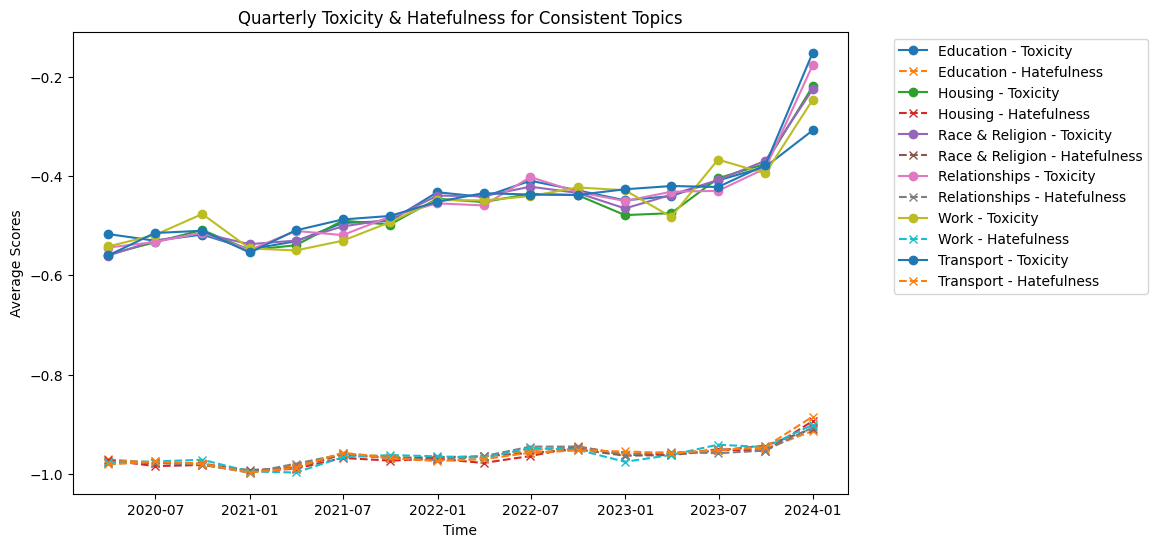

In [21]:
# Define the topics of interest
consistent_topics = ['Education', 'Housing', 'Race & Religion', 'Relationships', 'Work', 'Transport']

# Filter results_df for consistent topics only
consistent_df = results_df[results_df['topic'].isin(consistent_topics)]

# Ensure 'timestamp' is a datetime object and drop rows with null timestamps
consistent_df['timestamp'] = pd.to_datetime(consistent_df['timestamp'], errors='coerce')
consistent_df = consistent_df.dropna(subset=['timestamp'])

# Set 'timestamp' as the index to group by time period
consistent_df = consistent_df.set_index('timestamp')

# Calculate quarterly averages for toxicity and hatefulness scores by topic
consistent_quarterly_avg = consistent_df.groupby(['topic', pd.Grouper(freq='Q')])[['toxic_score', 'hateful_score']].mean().reset_index()

# Plot quarterly trends for each consistent topic
plt.figure(figsize=(10, 6))
for topic in consistent_topics:
    topic_data = consistent_quarterly_avg[consistent_quarterly_avg['topic'] == topic]
    plt.plot(topic_data['timestamp'], topic_data['toxic_score'], label=f'{topic} - Toxicity', marker='o')
    plt.plot(topic_data['timestamp'], topic_data['hateful_score'], linestyle='--', label=f'{topic} - Hatefulness', marker='x')

plt.title("Quarterly Toxicity & Hatefulness for Consistent Topics")
plt.xlabel("Time")
plt.ylabel("Average Scores")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

We can see the trends in toxicity and hatefulness over time, and at different periods there are different topics leading in toxicity and hatefulness. For example, education started off being the highest topic for toxicity back in 2020, but now in 2024, relationships is the topic that is leading in toxicity.

## Overall Conclusion Points
Based on the results of the consistent topic analysis, we observed the following key insights:

- Consistent Levels of Toxicity and Hatefulness: Across topics like Education, Relationships, Housing, Work, and Race & Religion, toxicity and hatefulness scores show patterns that align with general societal expectations. Scores remain relatively stable over time, with small increases potentially reflecting evolving discussions around sensitive topics.

- Topic-Specific Observations:

        - Education: This topic shows slightly lower toxicity levels but experiences some variance in hatefulness when compared to other topics like Housing. This finding may underscore the polarized opinions surrounding educational policies, stress, and competitiveness.

        - Housing: Although not significantly different in toxicity or hatefulness, slight elevations in both metrics for Housing could reflect societal frustrations around affordability and accessibility challenges. Housing policies and availability are often topics of tension and personal impact, contributing to elevated critical discourse.

        - Race & Religion: Consistently high toxicity and hatefulness scores for this topic highlight the challenging nature of discussions around sensitive cultural or societal issues. The FN (false negatives) in detection for this topic suggest nuanced language use, such as coded expressions or indirect hatefulness, which might evade detection and require model fine-tuning.

        - Relationships: Toxicity and hatefulness levels in Relationships show consistency without large variations, though certain outliers in hatefulness indicate emotionally charged interactions in personal matters.

        - Transport: This topic typically displays lower toxicity and hatefulness, which aligns with its functional or logistical nature. However, spikes in toxicity during specific incidents (e.g., delays, policy changes) highlight event-driven discourse and may benefit from monitoring during significant disruptions.

- Recommendations:
    - Threshold Adjustments: For topics with high toxicity and false negatives (e.g., Race & Religion), consider adjusting model thresholds or adding context-specific training to improve detection accuracy.
    - Sensitivity Prioritization: Increase sensitivity for Race & Religion and Relationships, as these appear more prone to false negatives. Monitoring these areas closely could improve moderation quality.
    - Tailored Moderation Strategies: Topics like Education and Housing may benefit from separate moderation strategies that account for nuanced or sensitive policy-related discussions.